In [ ]:
import random
import numpy as np

In [ ]:
# parameters of all program that can be adjust in the future
game_parameters = {
    'map_size': 4,

    ###### VALUE GENERATION ######
    'prob_2': 6,
    'prob_4': 3,
    'prob_8': 1,

    ####### REWARD FACTORS #######
    'tick_reward_factor': 1.2,
    'max_num_reward_factor': 1.5,
    'sur_dif_reward_factor': 0.75,

    ########## Q Value ##########
    'discount_factor': 0.618,
    'q_learning_rate': 0.7,

    ##### Training & Testing #####
    'train_episodes': 100,
    'test_episodes': 50,

    'baseline_learning_rate': 0.01,

    'MIN_REPLAY_SIZE': 1000,
    'epsilon': 1,
    'max_epsilon': 1, 
    'min_epsilon': 0.01,
    'decay': 0.01,
}

# The Game 2048
All function completed on 10/25/21 <br>
Wrapped in class on 10/26/21


In [ ]:
class game2048():
  def __init__(self, size):
    self.width = size
    self.map = self.init_map_gen()


  def init_map_gen(self):
    '''
      generate map based on different size
    '''

    arr = [[0 for i in range(self.width)] for i in range(self.width)]
    return arr
  
  def checkValid_x(self, x):
    '''
      check the validity of the row(x) had been chosed and suggest the columns(y) available
    '''
    
    count = 0
    valid = True
    valid_squares = []
    for i in range(len(self.map[x])):
      if self.map[x][i] == 0:
        valid_squares.append(i)
      else:
        count += 1
        if count == self.width:
          valid = False
  
    return valid, valid_squares


  def generation(self):
    '''
      generate new value and plug it in to the map
    '''
    
    valid = False
    while valid != True:
      x = random.randint(0, self.width-1)
      valid, valid_squares = self.checkValid_x(x)

    y_ind = random.randint(0, len(valid_squares)-1)
    y = valid_squares[y_ind]

    value_ind = random.randint(1,10)
    if value_ind <= 6:
      value = 2
    elif value_ind <= 9:
      value = 4
    elif value_ind == 10:
      value = 8

    self.map[x][y] = value
    
    return self.map
  
  def check_zero(self, arr):
    '''
      seperate the zero part and non_zero part of an array

      input:
        [0,4,1,0]
      output:
        [4,1], [0,0]
    '''

    non_zero = []
    zero = []
    for j in range(0, self.width):
        if arr[j] != 0:
          non_zero.append(arr[j])
        else:
          zero.append(0)

    return non_zero, zero

  def add(self, arr):
    '''
      add a row of array
      
      input:
        [0,2,2,0]
      output:
        [4], [0,0,0]
    '''

    non_zero, zero = self.check_zero(arr)
    for i in range(len(non_zero)-1):
      if non_zero[i] == non_zero[i+1]:
        non_zero[i] += non_zero[i+1]
        non_zero[i+1] = 0

    non_zero, zero = self.check_zero(non_zero+zero)
    
    return non_zero, zero
  
  def hor_ver_transform(self, arr_2d):
    '''
      to transform the matrix 90 degree

      input:
        [[0, 4], [0, 2]] 
      output:
        [[0, 0], [4, 2]]
    '''
    width = len(arr_2d)
    alted_map = [[] for i in range(width)]
    for i in range(width):
      for j in range(width):
        alted_map[j].append(arr_2d[i][j])
  
    return alted_map

  def left(self, arr_2d):
    '''
      change the map to the left
    '''

    width = len(arr_2d)
    non_zero = []
    zero = []
    alted_map = []
    for i in range(width):
      for j in range(0, width):
        if arr_2d[i][j] != 0:
          non_zero.append(arr_2d[i][j])
        else:
          zero.append(0)
    
      non_zero, zero = self.add(non_zero+zero)
      alted_map.append(non_zero+zero)
      non_zero = []
      zero = []

    return alted_map

  def right(self, arr_2d):
    '''
      change the map to the right
    '''

    width = len(arr_2d)
    non_zero = []
    zero = []
    alted_map = []
    for i in range(width):
      for j in range(0, width):
        if arr_2d[i][j] != 0:
          non_zero.append(arr_2d[i][j])
        else:
          zero.append(0)
    
      non_zero, zero = self.add(zero+non_zero)
      alted_map.append(zero+non_zero)
      non_zero = []
      zero = []

    return alted_map

  def down(self, arr_2d):
    '''
      change the map to the down
    '''

    alted_map = self.hor_ver_transform(arr_2d)
    alted_map = self.right(alted_map)
    alted_map = self.hor_ver_transform(alted_map)

    return alted_map

  def up(self, arr_2d):
    '''
      change the map to the up
    '''

    alted_map = self.hor_ver_transform(arr_2d)
    alted_map = self.left(alted_map)
    alted_map = self.hor_ver_transform(alted_map)

    return alted_map

  def check_frozed_help(self, arr):
    '''
      helper function of check_frozed
      check if there are same number that can be combined

      ex.
        [2,2] -> True
        [2,1] -> False 
    '''

    for i in range(1, len(arr)):
      if arr[i] == arr[i-1]:
        return True

    return False

  def check_frozed(self):
    map_tr = self.hor_ver_transform(self.map)

    for i in range(self.width):

      non_zero, a = self.check_zero(self.map[i])
      non_zero_tr, b = self.check_zero(map_tr[i])
      if len(a+b) != 0:
        return False

      if self.check_frozed_help(non_zero) or self.check_frozed_help(non_zero_tr):
        return False
  
    return True

  def change_unavailable_step(self, step):
    '''
      check if the step is available, if not, then
      action:
        0 -> 2
        1 -> 3
        2 -> 0
        3 -> 1
    '''
    map = self.map
    map_tr = self.hor_ver_transform(map)
    
    hor_avail = False
    ver_avail = False

    for i in range(self.width):
      non_zero, a = self.check_zero(map[i])
      non_zero_tr, b = self.check_zero(map_tr[i])
      
      if self.check_frozed_help(non_zero):
        hor_avail = True
      if self.check_frozed_help(non_zero_tr):
        ver_avail = True
      
    if not hor_avail:
      if step == 2:
        return int(0)
      if step == 3:
        return int(1)
    if not ver_avail:
      if step == 0:
        return int(2)
      if step == 1:
        return int(3)
    
    return step

  def display(self):
    '''
      for human players, display the map 
    '''

    for i in range(self.width):
      for j in range(self.width):
        print(f'{self.map[i][j]:4d}', end = "|")
      print('\n','-'*(5*self.width))
  
  def human_play(self):
    
    self.map = self.init_map_gen()

    self.map = self.generation()
    while True:
      self.map = self.generation()

      if self.check_frozed():
        self.display()
        print('you lose')
        break
      
      self.display()
      control = input("choose action(wasd), press z to end the game ")
      if control == 'w':
        self.map = self.up(self.map)
      elif control == 's':
        self.map = self.down(self.map)
      elif control == 'a':
        self.map = self.left(self.map)
      elif control == 'd':
        self.map = self.right(self.map)
      elif control == 'z':
        print('game abort')
        break

# Play Game

In [ ]:
size = int(input('choose the size of the map '))
new_game = game2048(size)
new_game.human_play()

choose the size of the map 4
   0|   0|   0|   0|
 --------------------
   8|   0|   0|   0|
 --------------------
   0|   0|   2|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
choose action(wasd), press z to end the game w
   8|   0|   2|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
   0|   4|   0|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
choose action(wasd), press z to end the game a
   8|   2|   0|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
   4|   0|   0|   2|
 --------------------
   0|   0|   0|   0|
 --------------------
choose action(wasd), press z to end the game w
   8|   2|   0|   2|
 --------------------
   4|   0|   0|   0|
 --------------------
   0|   2|   0|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
choose action(wasd), press z to end the game a
   8|   4|   0|   0|
 --------------------
   4|   0|   2|   0|
 --------------------
   2|   0

# Set Environment
Completed and Wrapped on 10/26/21


In [ ]:
class env2048():
  def __init__(self, size, tick_reward_factor=1.2, max_num_reward_factor=1.5, sur_dif_reward_factor=0.75):
    #reward factors
    self.tick_reward_factor = tick_reward_factor
    self.max_num_reward_factor = max_num_reward_factor
    self.sur_dif_reward_factor = sur_dif_reward_factor


    self.game = game2048(size)
    self.game.width = size

    self.tick = 0

    #self.game.display()
  
  def check_non_zero(self, arr):
    a = []
    for i in arr:
      if i != 0:
        a.append(i)
    
    return a
  
  def reward_0(self, done, tick=0):
    '''
      reward when not dead
    '''
    if done:
      return 0
    else:
      return 1

  def reward_1(self, done, tick=0):
    '''
    reward when:
      get bigger number
      survive longer
      the less the difference with surrounding blocks
    '''
    if done:
      return 0
    
    max_num = 0
    sur_dif = 0
    for i in range(self.game.width-1):
      for j in range(self.game.width-1):
        if self.game.map[i][j] > max_num:
          max_num = self.game.map[i][j]
          non_zero = self.check_non_zero([self.game.map[i+1][j], self.game.map[i-1][j], self.game.map[i][j+1], self.game.map[i][j-1]])
          sur_dif = sum(non_zero)
          sur_dif -= len(non_zero)*self.game.map[i][j]

    reward = self.tick_reward_factor*tick + self.max_num_reward_factor*max_num + self.sur_dif_reward_factor*sur_dif

    return reward

  def step(self, action, type_reward=0):
    done = False

    if action == 0:
      self.game.map = self.game.up(self.game.map)
    elif action == 1:
      self.game.map = self.game.down(self.game.map)
    elif action == 2:
      self.game.map = self.game.left(self.game.map)
    elif action == 3:
      self.game.map = self.game.right(self.game.map)
    
    self.game.map = self.game.generation()
    
    if self.game.check_frozed():
      done = True
    
    self.tick += 1

    next_state = np.array(self.game.map)

    if type_reward == 0:
      reward = self.reward_0(done, self.tick)
    elif type_reward == 1:
      reward = self.reward_1(done, self.tick)
        
    return next_state, reward, done

  def reset(self):

    self.game.map = self.game.init_map_gen()
    self.game.map = self.game.generation()
    self.game.map = self.game.generation()

    self.tick = 0
    return np.array(self.game.map)
  
  def change_unavailable_step(self, step):
    '''
      check if the step is available, if not, then
      action:
        0 -> 2
        1 -> 3
        2 -> 0
        3 -> 1
    '''
    map = self.game.map
    map_tr = self.hor_ver_transform(map)
    
    hor_avail = False
    ver_avail = False

    for i in range(self.width):
      non_zero, a = self.check_zero(map[i])
      non_zero_tr, b = self.check_zero(map_tr[i])
      
      if self.check_frozed_help(non_zero):
        hor_avail = True
      if self.check_frozed_help(non_zero_tr):
        ver_avail = True
      
    if not hor_avail:
      if step == 2:
        return int(0)
      if step == 3:
        return int(1)
    if not ver_avail:
      if step == 0:
        return int(2)
      if step == 1:
        return int(3)
    
    return step

  def action_space(self):
    return [0, 1, 2, 3]
  
  def obs_space(self):
    return self.game.map

In [ ]:
a = env2048(4)
a.reset()
a.game.display()
print('='*15)
a.step(0)
a.game.display()
print(a.game.change_unavailable_step(1))

   0|   0|   2|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
   0|   2|   0|   0|
 --------------------
   0|   2|   2|   0|
 --------------------
   0|   0|   2|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
1


#Set Agent
First Draft Finished at 11/16/2021 <br>
- when agent stuck at situation where there are only limited actions to choose from (i.e. left or right, up or down), and it had choose the wrong action (i.e. choose up or down when there only left, right is available), the program will stuck. <br>
- Solution:<br>
change the environment and return only available actions to choose from. <br>

- Sample Situation:<br>
the only option available are left or right, however it choose 1, which is down, and the program just stucks <br>
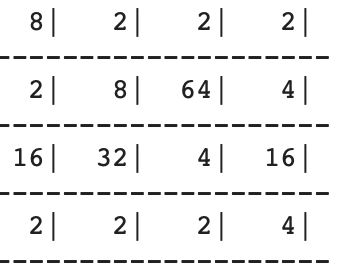


### Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from collections import deque

import numpy

In [ ]:
# import parameter from dictionary above

### Environment
tick_reward_factor = game_parameters['tick_reward_factor']
max_num_reward_factor = game_parameters['max_num_reward_factor']
sur_dif_reward_factor = game_parameters['sur_dif_reward_factor']
map_size = game_parameters['map_size']

### Agent
train_episodes = game_parameters['train_episodes']
test_episodes = game_parameters['test_episodes']
MIN_REPLAY_SIZE = game_parameters['MIN_REPLAY_SIZE']
baseline_learning_rate = game_parameters['baseline_learning_rate']

### Q Value
discount_factor = game_parameters['discount_factor']
q_learning_rate = game_parameters['q_learning_rate']


env = env2048(map_size, tick_reward_factor, max_num_reward_factor, sur_dif_reward_factor)

action_space = np.array(env.action_space())
obs_space = np.array(env.obs_space())
obs_space_1d = obs_space.flatten()
print('action space: {}'.format(action_space))
print('observation space (human POV):')
env.game.display()
print('\n observation space (agent POV): \n{})'.format(obs_space))
print('change step', env.game.change_unavailable_step(1))

action space: [0 1 2 3]
observation space (human POV):
   0|   0|   0|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
   0|   0|   0|   0|
 --------------------
   0|   0|   0|   0|
 --------------------

 observation space (agent POV): 
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]])
change step 3


### Agents

In [ ]:
def cnn_layer(input_shape):
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  
  return model

In [ ]:
def baseline_agent(obs_shape, action_shape, learning_rate=0.001):
  '''
  input: flattened obs shape, action shape
  output: model of baseline agent
  '''
  init = tf.keras.initializers.HeUniform()
  #model.add(cnn_layer(obs_shape))
  model.add(keras.layers.Dense(64, input_shape=obs_shape, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(12, activation='relu', kernel_initializer=init))
  model.add(keras.layers.Dense(action_shape, activation='linear', kernel_initializer=init))
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(lr=learning_rate), metrics=['accuracy'])

  return model

### Training

In [ ]:
def train(env, replay_memory, model, target_model, done, MIN_REPLAY_SIZE=1000, learning_rate=0.7, discount_factor=0.618):
    if len(replay_memory) < MIN_REPLAY_SIZE:
        return

    batch_size = 64 * 2
    mini_batch = random.sample(replay_memory, batch_size)
    current_states = np.array([transition[0] for transition in mini_batch])
    current_states = current_states.flatten()

    current_qs_list = model.predict(current_states)
    new_current_states = np.array([transition[3] for transition in mini_batch])
    future_qs_list = target_model.predict(new_current_states)

    X = []
    Y = []
    for index, (observation, action, reward, new_observation, done) in enumerate(mini_batch):
        if not done:
            max_future_q = reward + discount_factor * np.max(future_qs_list[index])
        else:
            max_future_q = reward

        current_qs = current_qs_list[index]
        try:
          current_qs[action] = (1 - learning_rate) * current_qs[action] + learning_rate * max_future_q
        except IndexError:
          print('current_qs: {}, action: {}'.format(current_qs, action))

        X.append(observation)
        Y.append(current_qs)
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

In [ ]:
a = baseline_agent(obs_space.shape, len(action_space))
a.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 4, 64)             320       
                                                                 
 dense_34 (Dense)            (None, 4, 12)             780       
                                                                 
 dense_35 (Dense)            (None, 4, 4)              52        
                                                                 
Total params: 1,152
Trainable params: 1,152
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
observation = env.reset()
print(observation.flatten())

[0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0]


NameError: ignored

In [ ]:
def main(epsilon=1, max_epsilon=1, min_epsilon=0.01, decay=0.01):
    # 1. Initialize the Target and Main models

    ### Main Model (updated every 4 steps)
    baseline_model = baseline_agent(obs_shape = obs_space.shape, action_shape = len(action_space))
    ### Target Model (updated every 100 steps)
    baseline_target_model = baseline_agent(obs_space.shape, action_shape = len(action_space))
    baseline_target_model.set_weights(baseline_model.get_weights())

    replay_memory = deque(maxlen=50_000)

    target_update_counter = 0

    # X = states, y = actions
    X = []
    y = []

    steps_to_update_target_model = 0

    for episode in range(1, train_episodes+1):
        total_training_rewards = 0
        episode_step = 0

        print('reseted')
        observation = env.reset()
        print(observation)
        env.game.display()

        done = False
        print('episode:{}'.format(episode))
        while not done:
        
            steps_to_update_target_model += 1

            random_number = np.random.rand()
            rand_action = np.random.randint(4)
            rand = True
            # 2. Explore using the Epsilon Greedy Exploration Strategy
            if random_number <= epsilon:
                # Explore
                action = action_space[rand_action]
                action = env.game.change_unavailable_step(action)
                rand = True

            else:
                # Exploit best known action
                # model dims are (batch, env.observation_space.n)
                
                # to flatten the input
                #input_obs = observation.flatten()
                #print('input_obs: {}, input_obs_shape: {}'.format(input_obs, input_obs.shape))
                #predicted = baseline_model.predict(input_obs)
                #print('length of model output: ', len(predicted))

                predicted = baseline_model.predict(observation)
                print(len(predicted))
                action = np.argmax(predicted)
                action = env.game.change_unavailable_step(action)
                rand = False

            if rand == True:
              print('random: true')
            else:
              print('random: false')
            env.game.display()
            print('action: ', action)
            print('='*25)
            new_observation, reward, done = env.step(action)
            replay_memory.append([observation, action, reward, new_observation, done])

            # 3. Update the Main Network using the Bellman Equation
            if steps_to_update_target_model % 4 == 0 or done:
                train(env, replay_memory, baseline_model, baseline_target_model, done)

            observation = new_observation
            total_training_rewards += reward

            if done:
                print('Total training rewards: {} after n steps = {} with final reward = {}'.format(total_training_rewards, episode, reward))
                total_training_rewards += 1

                if steps_to_update_target_model >= 100:
                    print('Copying main network weights to the target network weights')
                    baseline_target_model.set_weights(baseline_model.get_weights())
                    steps_to_update_target_model = 0
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay * episode)

In [ ]:
main()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
   0|   2|   0|  16|
 --------------------
action:  0
random: true
  16|   4| 128|   4|
 --------------------
   8|  64|  16|   2|
 --------------------
   4|   4|   8|   4|
 --------------------
   0|   0|   4|  16|
 --------------------
action:  2
random: true
  16|   4| 128|   4|
 --------------------
   8|  64|  16|   2|
 --------------------
   8|   8|   4|   2|
 --------------------
   4|  16|   0|   0|
 --------------------
action:  1
random: true
   0|   4|   0|   0|
 --------------------
  16|  64| 128|   4|
 --------------------
  16|   8|  16|   4|
 --------------------
   4|  16|   4|   4|
 --------------------
action:  2
random: true
   4|   0|   2|   0|
 --------------------
  16|  64| 128|   4|
 --------------------
  16|   8|  16|   4|
 --------------------
   4|  16|   8|   0|
 --------------------
action:  0
random: true
   4|  64|   2|   8|
 --------------------
  32|   8| 128|   0|
 --------------------
   4|  16|  

KeyboardInterrupt: ignored

In [ ]:
a = env2048(4)
a.game.map = [[16, 2, 4, 2],
              [8, 2, 32, 4], 
              [2, 32, 4, 8],
              [4, 64, 2, 4]]
a.game.display()
print('='*15)
a.step(1)
a.game.display()


  16|   2|   4|   2|
 --------------------
   8|   2|  32|   4|
 --------------------
   2|  32|   4|   8|
 --------------------
   4|  64|   2|   4|
 --------------------
  16|   8|   4|   2|
 --------------------
   8|   4|  32|   4|
 --------------------
   2|  32|   4|   8|
 --------------------
   4|  64|   2|   4|
 --------------------


# notes:
1. add get available action to env class
2. normalize input data, e.g. log_2(x)
3. add punishment if choose not avaliable action / force to choose availible action
4. hyperparameter tuning, e.g. learning rate, epsilon, discount factor...
5. lower steps per episode